In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.applications import  DenseNet121, VGG16, ResNet50, Xception, EfficientNetB7
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = r'C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\uygulamali_sinir_proje\real-vs-fake'

file_paths = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

data_df = pd.DataFrame({'filepaths': file_paths, 'labels': labels})
print(data_df.head())
print(data_df.tail())

                                           filepaths labels
0  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
1  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
2  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
3  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
4  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
                                                filepaths labels
144851  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144852  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144853  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144854  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144855  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real


In [41]:
max_epoch = 50
batch_size = 32
img_size = (128, 128)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)
vs_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_directory("./real-vs-fake/train",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

test_gen = ts_gen.flow_from_directory("./real-vs-fake/test",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical', shuffle=False)

val_gen = vs_gen.flow_from_directory("./real-vs-fake/val",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical', shuffle=False)

Found 103236 images belonging to 2 classes.
Found 23240 images belonging to 2 classes.
Found 23236 images belonging to 2 classes.


In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = True

resnet50 = Sequential()
resnet50.add(base_model)

resnet50.add(Flatten())

resnet50.add(BatchNormalization())
resnet50.add(Dense(256, activation='relu'))
resnet50.add(Dropout(0.3))

resnet50.add(BatchNormalization())

resnet50.add(Dense(2, activation='softmax'))

resnet50.compile(optimizer=Adam(), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [6]:
model_checkpoint = ModelCheckpoint(
    filepath='best_model_resnet50.h5',
    monitor='val_loss',
    save_best_only=True,
)

In [8]:
history = resnet50.fit(train_gen,
                       validation_data=val_gen,
                       epochs=max_epoch,
                       callbacks=[model_checkpoint])

Epoch 1/50
3227/3227 [==============================] - 715s 217ms/step - loss: 0.3652 - accuracy: 0.8379 - val_loss: 0.3438 - val_accuracy: 0.8576
Epoch 2/50
3227/3227 [==============================] - 767s 238ms/step - loss: 0.1894 - accuracy: 0.9263 - val_loss: 1.0729 - val_accuracy: 0.6810
Epoch 3/50
3227/3227 [==============================] - 759s 235ms/step - loss: 0.1128 - accuracy: 0.9580 - val_loss: 1.0955 - val_accuracy: 0.5836
Epoch 4/50
3227/3227 [==============================] - 706s 219ms/step - loss: 0.1148 - accuracy: 0.9555 - val_loss: 0.1113 - val_accuracy: 0.9610
Epoch 5/50
3227/3227 [==============================] - 751s 233ms/step - loss: 0.0636 - accuracy: 0.9771 - val_loss: 0.2408 - val_accuracy: 0.9114
Epoch 6/50
3227/3227 [==============================] - 742s 230ms/step - loss: 0.0502 - accuracy: 0.9819 - val_loss: 0.2286 - val_accuracy: 0.9163
Epoch 7/50
3227/3227 [==============================] - 697s 216ms/step - loss: 0.0387 - accuracy: 0.9863 - val_

In [49]:
val_losses = history.history['val_loss']
min_val_loss = min(val_losses)
best_epoch = val_losses.index(min_val_loss) + 1

print(f"En düşük val_loss değeri: {min_val_loss:.4f}")
print(f"Bu değer {best_epoch}. epoch'ta elde edildi.")

En düşük val_loss değeri: 0.0436
Bu değer 49. epoch'ta elde edildi.


In [26]:
test_loss, test_acc = resnet50.evaluate(test_gen)
print(f"\nModelin Test Seti Üzerindeki Performansı:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

727/727 [==============================] - 58s 79ms/step - loss: 11.2007 - accuracy: 0.9565

Modelin Test Seti Üzerindeki Performansı:
Test Accuracy: 0.9565
Test Loss: 11.2007


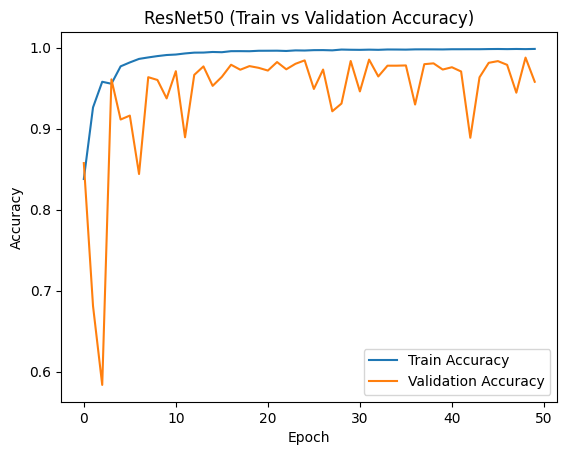

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 (Train vs Validation Accuracy)")
plt.legend()
plt.show()


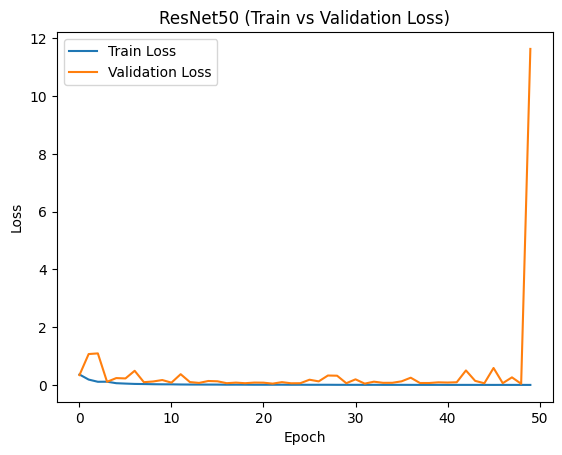

In [11]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet50 (Train vs Validation Loss)")
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
y_true = []
y_pred_probs = []

for i in range(len(test_gen)):
    img_batch, label_batch = next(test_gen)
    y_true.extend(np.argmax(label_batch, axis=1)) 
    preds = resnet50.predict(img_batch)  
    y_pred_probs.extend(preds)

1/1 [==============================] - 0s 28ms/step


In [53]:
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)

In [55]:
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        fake     0.9949    0.9178    0.9548     11620
        real     0.9237    0.9953    0.9582     11620

    accuracy                         0.9565     23240
   macro avg     0.9593    0.9565    0.9565     23240
weighted avg     0.9593    0.9565    0.9565     23240



In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred, average="weighted")
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_true, y_pred, average="weighted")
print(f"F1-score: {f1:.4f}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9593
Recall: 0.9565
F1-score: 0.9565
Accuracy: 0.9565


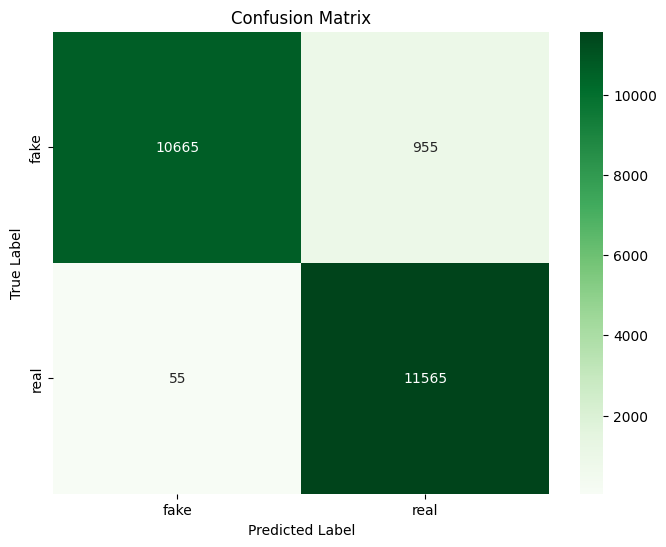

In [57]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()